In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflowjs as tfjs


In [2]:
directory = '/Users/esens/Python/SearchNBlogWithoutAds_Crawler'
train_dir = directory+'/train'
validation_dir = directory+'/validation'

train_image_dir = os.path.join(train_dir, 'image')  
train_advertise_dir = os.path.join(train_dir, 'advertise')  

validation_image_dir = os.path.join(validation_dir, 'image')
validation_advertise_dir = os.path.join(validation_dir, 'advertise')


In [3]:

num_image_tr = len(os.listdir(train_image_dir))
num_advertise_tr = len(os.listdir(train_advertise_dir))

num_image_val = len(os.listdir(validation_image_dir))
num_advertise_val = len(os.listdir(validation_advertise_dir))

total_train = num_image_tr + num_advertise_tr
total_val = num_image_val + num_advertise_val

In [4]:
print('total training image images:', num_image_tr)
print('total training advertise images:', num_advertise_tr)
print('num_image_tr : ' , num_image_tr);

print('total validation image images:', num_image_val)
print('total validation advertise images:', num_advertise_val)
print("--")
print("Total training images:", total_train)
print("Total validation images:", total_val)

total training image images: 46
total training advertise images: 46
num_image_tr :  46
total validation image images: 14
total validation advertise images: 14
--
Total training images: 92
Total validation images: 28


In [26]:
batch_size = 6
epochs = 10
IMG_HEIGHT = 120
IMG_WIDTH = 240

In [27]:
#for training data 
train_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our training data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           class_mode='binary')

Found 90 images belonging to 2 classes.


In [28]:
#for validation data 
validation_image_generator = ImageDataGenerator(rescale=1./255) # Generator for our validation data
val_data_gen = validation_image_generator.flow_from_directory(batch_size=batch_size,
                                                              directory=validation_dir,
                                                              target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                              class_mode='binary')

Found 26 images belonging to 2 classes.


In [29]:
sample_training_images, _ = next(train_data_gen)

In [30]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

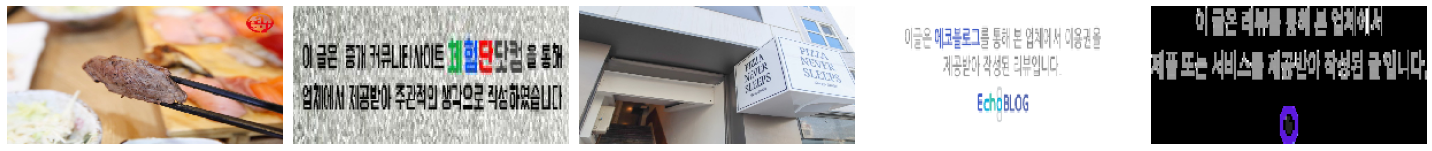

In [31]:
plotImages(sample_training_images[:5])
# create the model
def create_model():
    model = Sequential([
        Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
        MaxPooling2D(),
        Conv2D(32, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Conv2D(64, 3, padding='same', activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

In [32]:
model = create_model();
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 120, 240, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 60, 120, 16)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 120, 32)       4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 30, 60, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 30, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 30, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)            

In [33]:
# 모델 저장
checkpoint_path = "model_0716_v1(batch-4)/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path, verbose=1, save_weights_only=True,
    # 10번째 에포크에서 저장
    period=10)
checkpoint_path

'model_0716_v1(batch-4)/cp-{epoch:04d}.ckpt'

In [34]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    callbacks =[cp_callback],
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

Epoch 1/10
15/15 [==============================] - 2s 165ms/step - loss: 1.4082 - accuracy: 0.5222 - val_loss: 0.5971 - val_accuracy: 0.5417
Epoch 2/10
15/15 [==============================] - 2s 153ms/step - loss: 0.3987 - accuracy: 0.7444 - val_loss: 3.0798 - val_accuracy: 0.5000
Epoch 3/10
15/15 [==============================] - 2s 151ms/step - loss: 0.6574 - accuracy: 0.7778 - val_loss: 0.4417 - val_accuracy: 0.5833
Epoch 4/10
15/15 [==============================] - 2s 148ms/step - loss: 0.2319 - accuracy: 0.8667 - val_loss: 0.2633 - val_accuracy: 0.8333
Epoch 5/10
15/15 [==============================] - 2s 153ms/step - loss: 0.1877 - accuracy: 0.9000 - val_loss: 0.3578 - val_accuracy: 0.7917
Epoch 6/10
15/15 [==============================] - 2s 152ms/step - loss: 0.0949 - accuracy: 0.9667 - val_loss: 0.0994 - val_accuracy: 0.9583
Epoch 7/10
15/15 [==============================] - 2s 154ms/step - loss: 0.0274 - accuracy: 0.9889 - val_loss: 0.0442 - val_accuracy: 0.9583
Epoch 

/bin/sh: -c: line 0: syntax error near unexpected token `('
/bin/sh: -c: line 0: ` ls model_0716_v1(batch-4)'


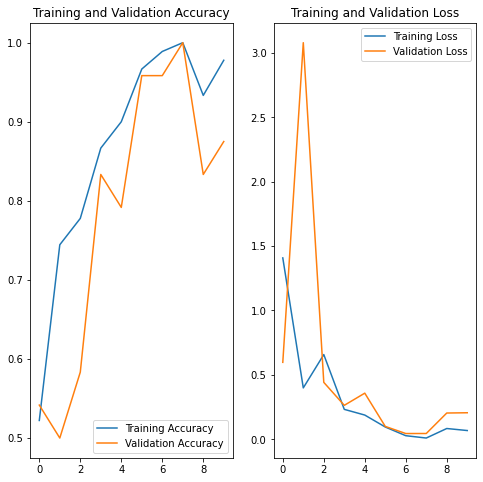

In [35]:
! ls {checkpoint_dir}
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [36]:
PATH =directory + "/test"

test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_data_gen = test_image_generator.flow_from_directory(directory=str(PATH),
                                                batch_size=batch_size,
                                                target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                class_mode='binary')
print("test_data_gen : " , test_data_gen)
print(test_data_gen.labels)

Found 8 images belonging to 2 classes.
test_data_gen :  <keras_preprocessing.image.directory_iterator.DirectoryIterator object at 0x7fb4c5d4c518>
[0 0 0 0 1 1 1 1]


In [37]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
print(latest)

# create model
model = create_model()
model.load_weights(latest)
tfjs.converters.save_keras_model(model, "tfjs_model")

model_0716_v1(batch-4)/cp-0010.ckpt


/Users/esens/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflowjs/converters/keras_h5_conversion.py:122: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  return h5py.File(h5file)


In [38]:
my_img_path = directory + "/test/image/3.jpg"
image = tf.keras.preprocessing.image.load_img(my_img_path,target_size=(IMG_HEIGHT, IMG_WIDTH))

input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.

#print("model shape : " , model.summary());
# print("input_arr : ", input_arr)

predictions_class = model.predict_classes(input_arr)
predictions = model.predict(input_arr)

print("========pridiction========")
print(test_data_gen.class_indices)
print("predictions class : " , predictions_class);
print("predictions class : " , predictions_class[0][0]);
print("predictions : " , predictions);
print("predictions argmax : ",np.argmax(predictions[0])); # same way
if predictions_class > 0:
    if "image" in my_img_path:
        print("correct!")
    else:
        print("not correct....")
else:
    if "advertise" in my_img_path:
        print("correct!")
    else:
        print("not correct....")
    

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
========pridiction========
{'advertise': 0, 'image': 1}
predictions class :  [[1]]
predictions class :  1
predictions :  [[148.04112]]
predictions argmax :  0
correct!
